## Image Focus and Astigmatism Classifier
- **Author:** [Aaron Woods](https://aaronwoods.info)
- **Date Created:** October,26, 2023
- **Repository:** [Image Classification on VSCode](https://insiders.vscode.dev/tunnel/midnightsim/c:/Users/User/Desktop/Image-Classification)

### Description
This script provides an end-to-end machine learning pipeline for image classification. It can categorize images as "In Focus" or "Out of Focus" while also detecting astigmatism-related issues. The design is modular, making it adaptable to various image classification tasks.

### Features
- Ingests data from Excel spreadsheets.
- Utilizes multiple machine learning models.
- Modular design for easy customization.

### Requirements

In [23]:
# ------------------------------
# Package Installation (Optional)
# ------------------------------
# Uncomment the following lines to install required packages if running on a new machine.

%pip install opencv-python numpy pandas matplotlib protobuf seaborn scikit-learn openpyxl

# ------------------------------
# TensorFlow Installation with GPU Support
# ------------------------------
# Note: TensorFlow versions above 2.10 are not supported on GPUs on native Windows installations.
# For more details, visit: https://www.tensorflow.org/install/pip#windows-wsl2_1

# Uncomment the following line to install TensorFlow if needed.
%pip install "tensorflow<2.11" --user


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [24]:
# ------------------------------
# System and TensorFlow Info Check
# ------------------------------
import platform
import tensorflow as tf

def get_system_info():
    """Get system and TensorFlow information."""
    system_info = {"Platform": platform.platform(), "Python Version": platform.python_version()}
    
    try:
        system_info.update({
            "TensorFlow Version": tf.__version__,
            "Num GPUs Available": len(tf.config.list_physical_devices('GPU'))
        })
        system_info['Instructions'] = (
            "You're all set to run your model on a GPU." 
            if system_info['Num GPUs Available'] 
            else (
                "No GPUs found. To use a GPU, follow these steps:\n"
                "  1. Install NVIDIA drivers for your GPU.\n"
                "  2. Install a compatible CUDA toolkit.\n"
                "  3. Install the cuDNN library.\n"
                "  4. Make sure to install the GPU version of TensorFlow."
            )
        )
    except ModuleNotFoundError:
        system_info['Instructions'] = (
            "TensorFlow is not installed. "
            "Install it using pip by running: !pip install tensorflow"
        )
    
    return system_info

def configure_gpu_memory_growth():
    """Set GPU memory consumption growth to avoid OOM errors."""
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Call functions to get system info and configure GPU memory.
system_info = get_system_info()
configure_gpu_memory_growth()

# Print system information.
formatted_info = "\n".join(f"{key}: {value}" for key, value in system_info.items())
print(formatted_info)

Platform: Windows-10-10.0.17763-SP0
Python Version: 3.9.18
TensorFlow Version: 2.10.1
Num GPUs Available: 1
Instructions: You're all set to run your model on a GPU.


In [25]:
# ------------------------------
# Import Libraries
# ------------------------------

# Standard Libraries
import os
import sys
import random
import math
import glob
import logging
from datetime import datetime
from collections import defaultdict, Counter

# Third-Party Libraries
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils import class_weight, resample
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers, applications
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.data import Dataset
from tensorflow.keras.models import load_model

# Other Imports
import pickle
import itertools
from matplotlib.legend_handler import HandlerTuple

# Type Annotations
from typing import List, Dict, Tuple, Union, Any, Optional


## Configuration

In [26]:
# Configuration Dictionary

# DOE_v2 Experiment has classweights working!

experiment_config = {
    'NAME': "Oct26_100pct_CW_SIM",            # Experiment name
    'RANDOM_SEED': 42,                             # Seed for reproducibility
    'PROBLEM_TYPE': 'Multi-Output',                # Problem type: Binary, Multi-Class, Multi-Output, Multi-Label
}

model_config = {
    'IMG_SIZE': 224,                               # Image input size
    'BATCH_SIZE': 16,                              # Batch size for training
    'TRAIN_SIZE': 0.8,                             # Fraction of data to use for training
    'VAL_SIZE': 0.5,                               # Fraction of data to use for validation
    'EPOCHS': 100,                                 # Number of training epochs
    'LEARNING_RATE': 0.001,                        # Learning rate 1e-3
    'EARLY_STOPPING_PATIENCE': 50,                 # Early stopping patience
    'REDUCE_LR_PATIENCE': 3,                       # Reduce learning rate on plateau patience
    'MIN_LR': 1e-6,                                # Minimum learning rate
}

label_mappings = {
    'Focus_Label': {'SharpFocus': 0, 'SlightlyBlurred': 1, 'HighlyBlurred': 2},
    'StigX_Label': {'OptimalStig_X': 0, 'ModerateStig_X': 1, 'SevereStig_X': 2},
    'StigY_Label': {'OptimalStig_Y': 0, 'ModerateStig_Y': 1, 'SevereStig_Y': 2},
}

augmentation_config = {
    'rotation_factor': 0.002,  # Specifies the rotation range applied to the data (in radians).
    'height_factor': (-0.18, 0.18),  # Specifies the range of random vertical shifts applied to the data.
    'width_factor': (-0.18, 0.18),  # Specifies the range of random horizontal shifts applied to the data.
    'contrast_factor': 0.5,  # Specifies the range of random contrast adjustments applied to the data.
}

# Combine Experiment, Model, Labels, and Augmentation Configurations
config = {
    'Experiment': experiment_config,
    'Model': model_config,
    'Labels': {'MAPPINGS': label_mappings},
    'Augmentation': augmentation_config
}

# Dataset Creation Configuration
csv_config = {
    'CSV': {
        'COLUMNS_TO_READ': ['ImageFile', 'Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']
    },
    'Thresholds': {
        'FOCUS_LOW': 30,                              # Lower focus threshold
        'FOCUS_HIGH': 60,                             # Upper focus threshold
        
        'STIGX_LOW': 1,                               # Lower astigmatism threshold
        'STIGX_HIGH': 2,                              # Upper astigmatism threshold
        
        'STIGY_LOW': 1,                               # Lower astigmatism threshold
        'STIGY_HIGH': 2,                              # Upper astigmatism threshold
    },
    'Paths': {
        'OLD_BASE_PATH': "D:\\DOE\\",
        
        # On Simulation Computer
        'DATA_FILE': "combined_output.csv",
        'NEW_BASE_PATH': "Y:\\User\\Aaron-HX38\\DOE\\", 
        
        # On Laptop
        # 'DATA_FILE': "combined_output_cleaned.csv",
        # 'NEW_BASE_PATH': "C:\\Users\\aaron.woods\\OneDrive - Thermo Fisher Scientific\\Desktop\\Dec 24\\",
    },
    'SAMPLE_FRAC': 1.0,                                # Fraction of the data for quicker prototyping (1.0 means use all data)
}

# Update the main configuration dictionary with the dataset configuration
config.update(csv_config)

# Set random seed for reproducibility
np.random.seed(config['Experiment']['RANDOM_SEED'])
tf.random.set_seed(config['Experiment']['RANDOM_SEED'])

## Data Loading

In [27]:
### Functions for Preparation of CSV

def read_csv(config: Dict):
    # Functionality to read the data
    data_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"Error: File does not exist - {data_file_path}")
    try:
        data = pd.read_csv(data_file_path, usecols=config['CSV']['COLUMNS_TO_READ'])
        print("---> Data read successfully.")
        sample_frac = config.get('SAMPLE_FRAC', 1.0)
        if 0 < sample_frac < 1.0:
            data = data.sample(frac=sample_frac).reset_index(drop=True)
            print(f"---> Data sampled: Using {sample_frac * 100}% of the available data.")
    except Exception as e:
        raise ValueError(f"Error: Could not read data - {e}") from e
    return data

def update_image_paths(df):
    old_base_path = config['Paths']['OLD_BASE_PATH']
    new_base_path = config['Paths']['NEW_BASE_PATH']
    df['ImageFile'] = df['ImageFile'].str.replace(old_base_path, new_base_path, regex=False)
    print("---> Image paths updated.")
    return df


def clean_csv(df: pd.DataFrame, save_cleaned: bool = False) -> pd.DataFrame:
    def is_valid_string(image_path) -> bool:
        return isinstance(image_path, str)
    
    def does_file_exist(image_path) -> bool:
        return os.path.exists(image_path)
    
    def can_image_be_read(image_path) -> bool:
        img = cv2.imread(image_path)
        return img is not None
    
    removal_reasons = defaultdict(list)
    total_rows = len(df)
    csv_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    print("Cleaning CSV file...")
    for index, row in enumerate(df.itertuples()):
        progress = (index + 1) / total_rows * 100
        print(f"\rProgress: {progress:.2f}%", end="")
        
        image_path = row.ImageFile
        reason = None
        
        if not is_valid_string(image_path):
            reason = "Invalid ImageFile value - not a string"
        elif not does_file_exist(image_path):
            reason = "File does not exist"
        elif not can_image_be_read(image_path):
            reason = "Image can't be read"
        
        if reason:
            removal_reasons[reason].append(index)
    
    invalid_rows = [index for indices in removal_reasons.values() for index in indices]
    df.drop(index=invalid_rows, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    print("\n\nSummary of row removals:")
    for reason, indices in removal_reasons.items():
        print(f"{len(indices)} rows removed due to: {reason}")
        print(f"Row indices: {indices}")
    
    if save_cleaned and csv_file_path:
        cleaned_csv_file_path = f"{os.path.splitext(csv_file_path)[0]}_cleaned.csv"
        df.to_csv(cleaned_csv_file_path, index=False)
        print(f"Cleaned CSV saved to: {cleaned_csv_file_path}")
    
    return df


In [28]:
### Generating labels

def generate_thresholds(label_key):
    low_key = f"{label_key.split('_')[0].upper()}_LOW"
    high_key = f"{label_key.split('_')[0].upper()}_HIGH"
    return config.get('Thresholds', {}).get(low_key, 0), config.get('Thresholds', {}).get(high_key, 0)

def generate_single_label(df_copy, label_key, offset_column, choices_dict):
    low_threshold, high_threshold = generate_thresholds(label_key)
    conditions = [
        (df_copy[offset_column].abs() <= low_threshold),
        (df_copy[offset_column].abs() > low_threshold) & (df_copy[offset_column].abs() <= high_threshold),
        (df_copy[offset_column].abs() > high_threshold)
    ]
    choices = list(choices_dict.keys())
    df_copy[label_key] = np.select(conditions, choices, default='Unknown')
    le = LabelEncoder()
    df_copy[label_key] = le.fit_transform(df_copy[label_key])
    return le

def generate_labels(df: pd.DataFrame):
    print("---> Generating labels for Focus, StigX, and StigY...")
    labels_config = config.get('Labels', {}).get('MAPPINGS', {})
    offset_column_mapping = {'Focus_Label': 'Focus_Offset (V)', 'StigX_Label': 'Stig_Offset_X (V)', 'StigY_Label': 'Stig_Offset_Y (V)'}

    df_copy = df.copy()
    label_encoders = {}

    for label_key, choices_dict in labels_config.items():
        offset_column = offset_column_mapping.get(label_key)
        if not offset_column:
            print(f"Warning: No offset column mapping found for '{label_key}'. Skipping label generation.")
            continue
        if offset_column not in df.columns:
            print(f"Warning: Column '{offset_column}' not found in DataFrame. Skipping label generation for '{label_key}'.")
            continue
        label_encoders[label_key] = generate_single_label(df_copy, label_key, offset_column, choices_dict)
        print(f"---> Labels generated for {label_key}")

    if config.get('Experiment', {}).get('PROBLEM_TYPE') == 'Multi-Output':
        df_copy['Multi_Output_Labels'] = df_copy.apply(lambda row: [row[key] for key in labels_config.keys()], axis=1)
        print("---> Multi-Output Labels generated.")
        
    return df_copy, label_encoders


In [29]:
### Shuffling and Splitting the Data

def shuffle_and_reset_index(data):
    print("---> Shuffling and resetting index...")
    shuffled_df = data.sample(frac=1, random_state=config['Experiment']['RANDOM_SEED']).reset_index(drop=True)
    print("---> Data shuffled and index reset.")
    return shuffled_df

def prepare_datasets(df: pd.DataFrame):
    """Prepare training, validation, and test datasets."""
    # Check if DataFrame is empty
    if df is None or df.empty:
        print("Warning: DataFrame is empty. Cannot proceed with data preparation.")
        return {'train': None, 'valid': None, 'test': None}
    # Split Data
    try:
        train_df, temp_df = train_test_split(df, test_size=1 - config['Model']['TRAIN_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
        val_df, test_df = train_test_split(temp_df, test_size=1 - config['Model']['VAL_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
    except ValueError:
        print("Not enough data to split into training, validation, and test sets.")
        return {'train': None, 'valid': None, 'test': None}
    print("---> Data split into training, validation, and test sets.")
    return {'train': train_df, 'valid': val_df, 'test': test_df}

In [30]:
### Computting Class Weights

def compute_class_weights_for_label(split: str, df: pd.DataFrame, label: str, label_encoders: Dict[str, LabelEncoder], all_records: List[Dict], is_multi_label: bool = False) -> None:
    y_data = df[label].values if is_multi_label else df[label]
    unique_labels = np.unique(y_data)
    class_weights = compute_class_weight('balanced', classes=unique_labels, y=y_data)
    class_weights_dict = dict(zip(unique_labels, class_weights))
    
    for cls, weight in class_weights_dict.items():
        cnt = Counter(y_data)[cls]
        original_class = label_encoders[label].inverse_transform([cls])[0]
        all_records.append({
            'split': split,
            'label': label,
            'class': original_class,
            'Count': cnt,
            'Weight': weight
        })

def compute_and_store_class_weights(datasets: Dict[str, pd.DataFrame], label_encoders: Dict[str, LabelEncoder]) -> pd.DataFrame:
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE', 'Binary')
    all_records = []
    
    for split, df in datasets.items():
        if df is None:
            continue
        for label in config['Labels']['MAPPINGS']:
            compute_class_weights_for_label(
                split, df, label, label_encoders, all_records, 
                is_multi_label=(problem_type == 'Multi-label')
            )
                
    df_class_weights = pd.DataFrame.from_records(all_records)
    df_class_weights.set_index(['split', 'label', 'class'], inplace=True)
    return df_class_weights

In [31]:
### Creating Tensorflow Datasets

def create_tf_datasets_from_dfs(dfs: Dict[str, pd.DataFrame], include_offset: bool = False) -> Dict[str, Dict[str, Any]]:
    """
    Create TensorFlow datasets from DataFrames for training, validation, and testing.
    """
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE')
    batch_size = config.get('Model', {}).get('BATCH_SIZE', 32)
    AUTOTUNE = tf.data.AUTOTUNE
    
    preprocessing_layers = create_preprocessing_layers()
    augmentation_layers = create_augmentation_layers()
    
    def load_and_preprocess_image(file_path: tf.Tensor, label: tf.Tensor, offset: Optional[tf.Tensor], augment: bool = False) -> Tuple:
        file_path_str = file_path.numpy().decode('utf-8')
        image = read_and_convert_image(file_path_str)
        image = preprocessing_layers(image)
        if augment:
            image = augmentation_layers(image)
            image = tf.clip_by_value(image, 0.0, 1.0)
        label = tf.cast(label, tf.int32)
        offset = tf.cast(offset, tf.float32) if offset is not None else None
        return (image, label, offset) if include_offset else (image, label)

    def prepare_dataset(file_paths, labels, offsets, augment):
        ds = tf.data.Dataset.from_tensor_slices((file_paths, labels, offsets))
        ds = ds.map(lambda file_path, label, offset: tf.py_function(
            func=load_and_preprocess_image,
            inp=[file_path, label, offset if offset is not None else tf.constant([], dtype=tf.float32), augment],
            Tout=[tf.float32, label.dtype, tf.float32] if include_offset else [tf.float32, label.dtype]
        ))
        return ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE) # If I have a lot of memory, I can use cache() here.

    tf_datasets = {'train': {}, 'valid': {}, 'test': {}}
    offset_column_mapping = {
        'Focus_Label': 'Focus_Offset (V)',
        'StigX_Label': 'Stig_Offset_X (V)',
        'StigY_Label': 'Stig_Offset_Y (V)'
    }

    for split, df in dfs.items():
        augment_data = (split == 'train')
        if problem_type in ['Multi-Class', 'Binary']:
            for label in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
                offset_column = offset_column_mapping.get(label)
                offsets = df[offset_column].values if include_offset else None
                tf_datasets[split][label] = prepare_dataset(df['ImageFile'].values, df[label].values, offsets, augment_data)
        
        elif problem_type == 'Multi-Output':
            labels = df[['Focus_Label', 'StigX_Label', 'StigY_Label']].values
            offsets = df[['Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']].values if include_offset else None
            tf_datasets[split]['Multi_Output'] = prepare_dataset(df['ImageFile'].values, labels, offsets, augment_data)
        
        else:
            print("Unknown problem type specified in config. Please check.")

    return tf_datasets

### Image Augmentation and Preprocessing

def create_preprocessing_layers() -> keras.Sequential:
    """Create preprocessing layers for resizing and rescaling images."""
    img_size = config['Model']['IMG_SIZE']
    return keras.Sequential([
        layers.Resizing(img_size, img_size),
        layers.Rescaling(1./255)
    ])

def create_augmentation_layers() -> keras.Sequential:
    """Create data augmentation layers."""
    aug_config = config['Augmentation']
    try:
        return keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(aug_config['rotation_factor']),
            layers.RandomTranslation(
                height_factor=aug_config['height_factor'],
                width_factor=aug_config['width_factor'],
                fill_mode="reflect"
            ),
            layers.RandomContrast(aug_config['contrast_factor']),
        ])
        
    except Exception as e:
        print(f"An error occurred while creating augmentation layers: {e}")
        return None

def read_and_convert_image(file_path: str) -> tf.Tensor:
    """Read an image from a file and convert it to a 3-channel tensor."""
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Failed to read the image.")
        return None
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    return tf.image.grayscale_to_rgb(image)

In [32]:
### Resample Datasets to deal with Imbalances (Optional)

def validate_inputs(datasets: Dict[str, pd.DataFrame], resample_label: str, resample_strategy: str) -> None:
    if not isinstance(datasets, dict):
        raise ValueError("Input datasets should be a dictionary.")
    if resample_strategy not in ["upsample", "downsample", "combined"]:
        raise ValueError("Invalid resample_strategy. Choose from 'upsample', 'downsample', or 'combined'.")
    for key, df in datasets.items():
        if resample_label not in df.columns:
            raise ValueError(f"'{resample_label}' is not a valid column in the {key} dataset.")

def target_count_for_strategy(label_counts: pd.Series, strategy: str) -> int:
    if strategy == "downsample":
        return label_counts.min()
    elif strategy == "upsample":
        return label_counts.max()
    return int(label_counts.median())

def iterative_resampling(df: pd.DataFrame, resample_strategy: str, resample_label: str) -> pd.DataFrame:
    label_counts = df[resample_label].apply(tuple).value_counts()
    target_count = target_count_for_strategy(label_counts, resample_strategy)
    subsets = [
        resample(
            df[df[resample_label].apply(tuple) == unique_label],
            replace=(label_counts[unique_label] < target_count),
            n_samples=target_count
        )
        for unique_label in label_counts.keys()
    ]
    return pd.concat(subsets).sample(frac=1).reset_index(drop=True)

def resample_datasets(datasets: Dict[str, pd.DataFrame], resample_label='Multi_Output_Labels', resample_strategy="downsample") -> Dict[str, pd.DataFrame]:
    validate_inputs(datasets, resample_label, resample_strategy)
    
    int32_columns = [col for col, dtype in datasets.get('train', pd.DataFrame()).dtypes.items() if dtype == 'int32']
    
    def process_dataset(key: str, df: pd.DataFrame) -> pd.DataFrame:
        if key != 'train':
            return df
        resampled_data = iterative_resampling(df, resample_strategy, resample_label)
        for col in int32_columns:
            resampled_data[col] = resampled_data[col].astype('int32')
        return resampled_data
    
    return {key: process_dataset(key, df) for key, df in datasets.items()}


### Data Loading Main Function

In [33]:
# 🚀 Enhanced Data Loading and Preprocessing Workflow

print("\n🔍 [START] Preprocessing CSV Data...")
data = read_csv(config)
data = update_image_paths(data)
# Uncomment the below line if you want to clean the CSV
data = clean_csv(data, save_cleaned=False)
data, label_encoders = generate_labels(data)
data = shuffle_and_reset_index(data)

print("\n📊 [LOAD] Preparing TensorFlow Datasets...")
datasets = prepare_datasets(data)
print("  🏋️‍♂️ Computing class weights for original datasets...")
df_class_weights = compute_and_store_class_weights(datasets, label_encoders)

print("\n  🔁 Resampling datasets... (Optional)")
resampled_datasets = resample_datasets(datasets, resample_label='Multi_Output_Labels', resample_strategy="upsample")
print("  🏋️‍♀️ Computing class weights for resampled datasets...")
rdf_class_weights = compute_and_store_class_weights(resampled_datasets, label_encoders)

print("\n🔧 [BUILD] Creating TensorFlow datasets from DataFrames...")
datasets = create_tf_datasets_from_dfs(datasets, include_offset=True)
resampled_datasets = create_tf_datasets_from_dfs(resampled_datasets, include_offset=True)

print("\n✅ [DONE] Preprocessing Complete!\n")



🔍 [START] Preprocessing CSV Data...
---> Data read successfully.
---> Image paths updated.
Cleaning CSV file...
Progress: 100.00%

Summary of row removals:
1 rows removed due to: File does not exist
Row indices: [188]
---> Generating labels for Focus, StigX, and StigY...
---> Labels generated for Focus_Label
---> Labels generated for StigX_Label
---> Labels generated for StigY_Label
---> Multi-Output Labels generated.
---> Shuffling and resetting index...
---> Data shuffled and index reset.

📊 [LOAD] Preparing TensorFlow Datasets...
---> Data split into training, validation, and test sets.
  🏋️‍♂️ Computing class weights for original datasets...

  🔁 Resampling datasets... (Optional)
  🏋️‍♀️ Computing class weights for resampled datasets...

🔧 [BUILD] Creating TensorFlow datasets from DataFrames...

✅ [DONE] Preprocessing Complete!



## Visualizing the Data

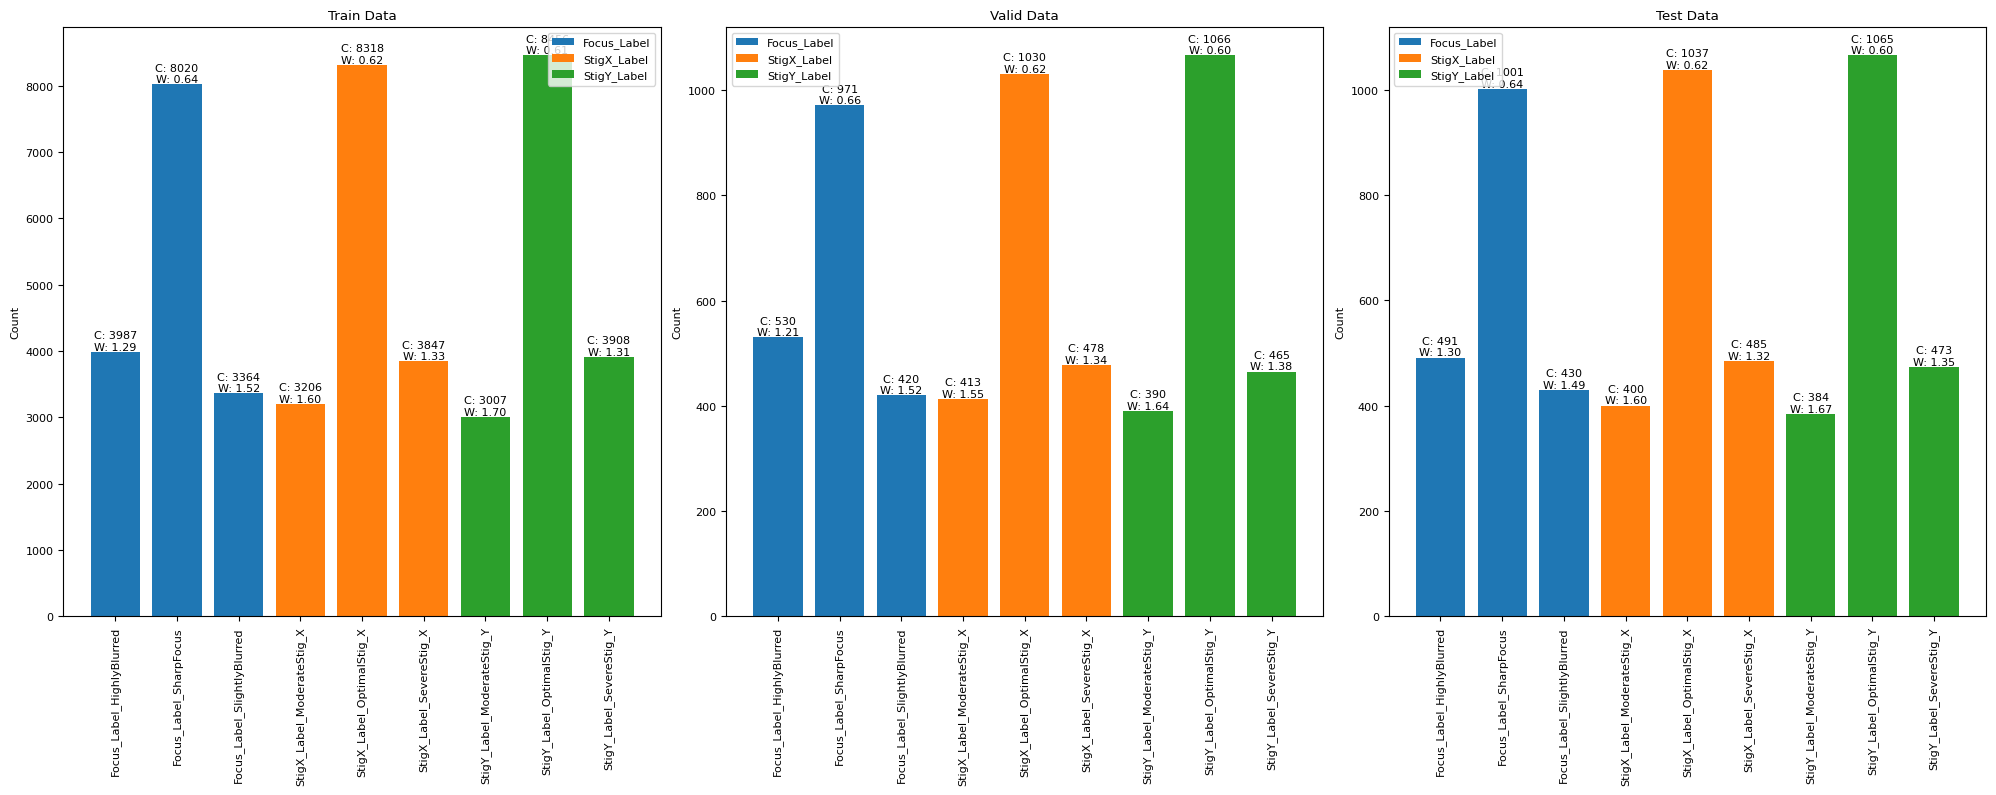

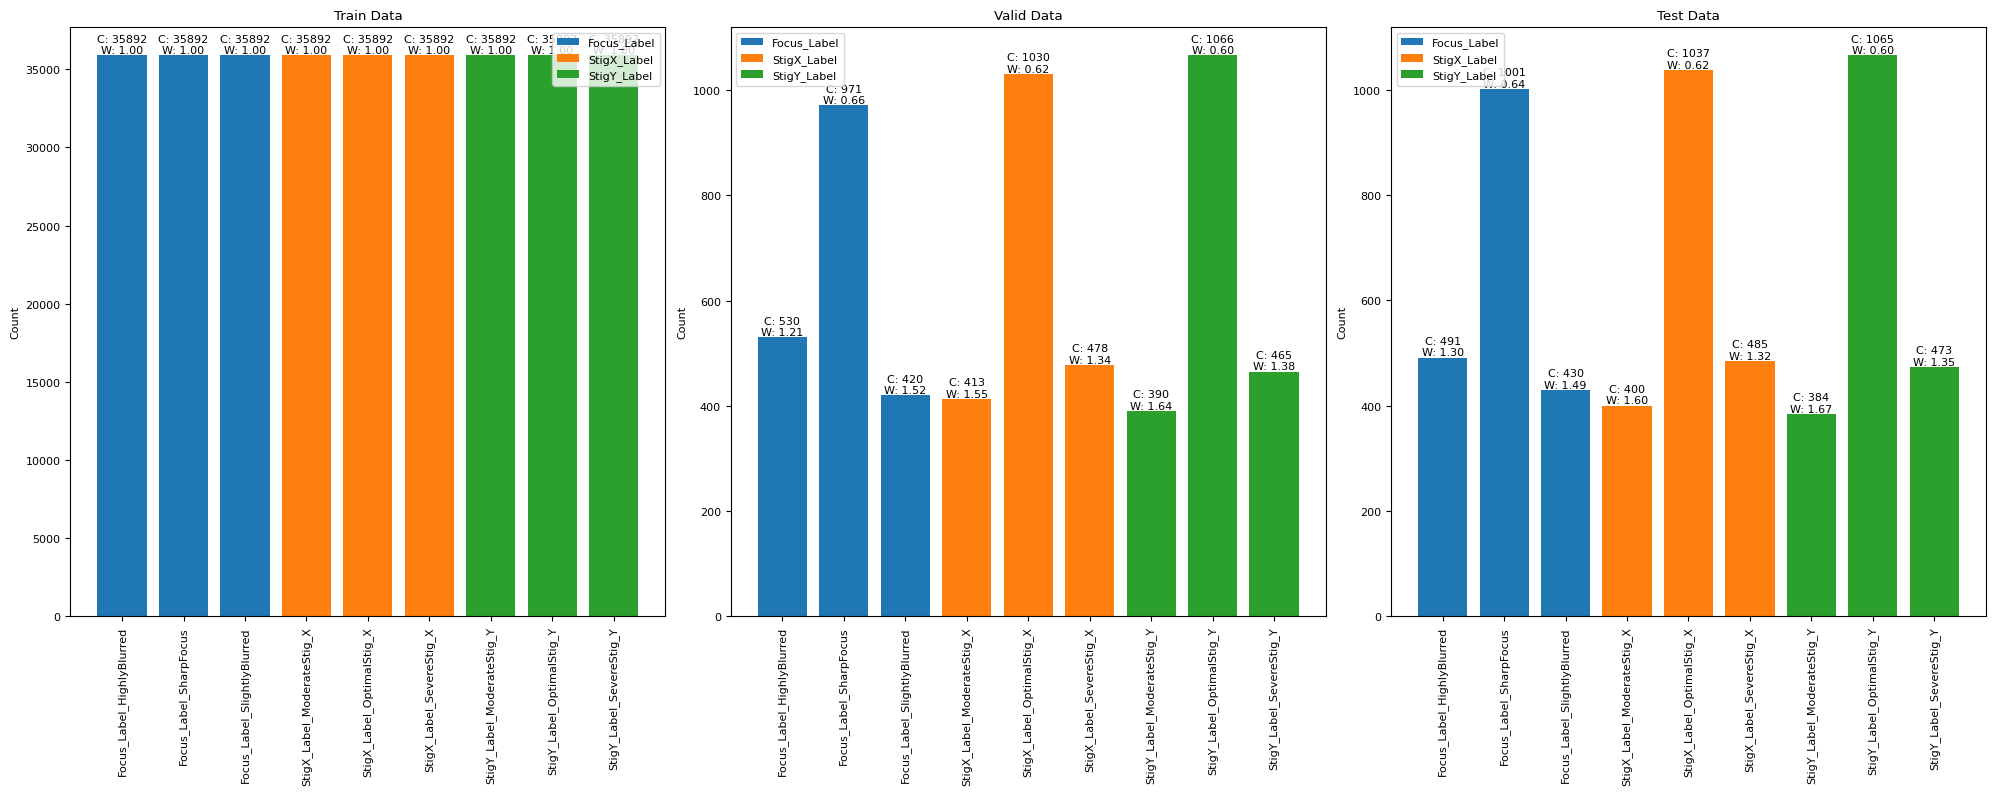

In [34]:
### Class Distributions
import matplotlib.pyplot as plt

def add_annotations(ax, bars, sub_df):
    """
    Adds annotations to the bars.
    """
    for bar, (_, row) in zip(bars, sub_df.iterrows()):
        x = bar.get_x() + bar.get_width() / 2.0
        y = bar.get_height() + 0.5  # Shift annotation slightly above the bar for clarity
        ax.annotate(f"C: {int(row['Count'])}\nW: {row['Weight']:.2f}", 
                    (x, y), 
                    ha='center', 
                    va='bottom', 
                    fontsize=8)

def plot_single_split(ax, df, split):
    """
    Plots the class distribution for a single split (train/test/valid).
    """
    filtered_df = df.loc[split]
    x_ticks = []
    x_tick_locs = []
    current_x = 0  # Keep track of the current x-location for ticks
    
    labels = filtered_df.index.get_level_values('label').unique()
    for label in labels:
        sub_df = filtered_df.loc[label]
        bars = ax.bar(sub_df.index, sub_df['Count'], label=f"{label}")
        add_annotations(ax, bars, sub_df)
        
        x_ticks.extend([f"{label}_{cls}" for cls in sub_df.index])
        x_tick_locs.extend([current_x + i for i in range(len(sub_df.index))])
        current_x += len(sub_df.index)  # Update the x-location for the next set of bars
    
    ax.legend()
    ax.set_xticks(x_tick_locs)  # Set tick locations
    ax.set_xticklabels(x_ticks, rotation=90, fontsize=8)  # Set tick labels
    ax.set_title(f"{split.capitalize()} Data")
    ax.set_ylabel("Count")  # Indicate that the bars represent counts


def plot_dataset_info(df):
    """
    Plots the class distribution for train, valid, and test splits.
    """
    splits = ['train', 'valid', 'test']
    fig, axs = plt.subplots(1, len(splits), figsize=(20, 8))
    
    for i, split in enumerate(splits):
        plot_single_split(axs[i], df, split)
        
    plt.tight_layout()
    plt.show()

# Example usage
plot_dataset_info(df_class_weights)
plot_dataset_info(rdf_class_weights)


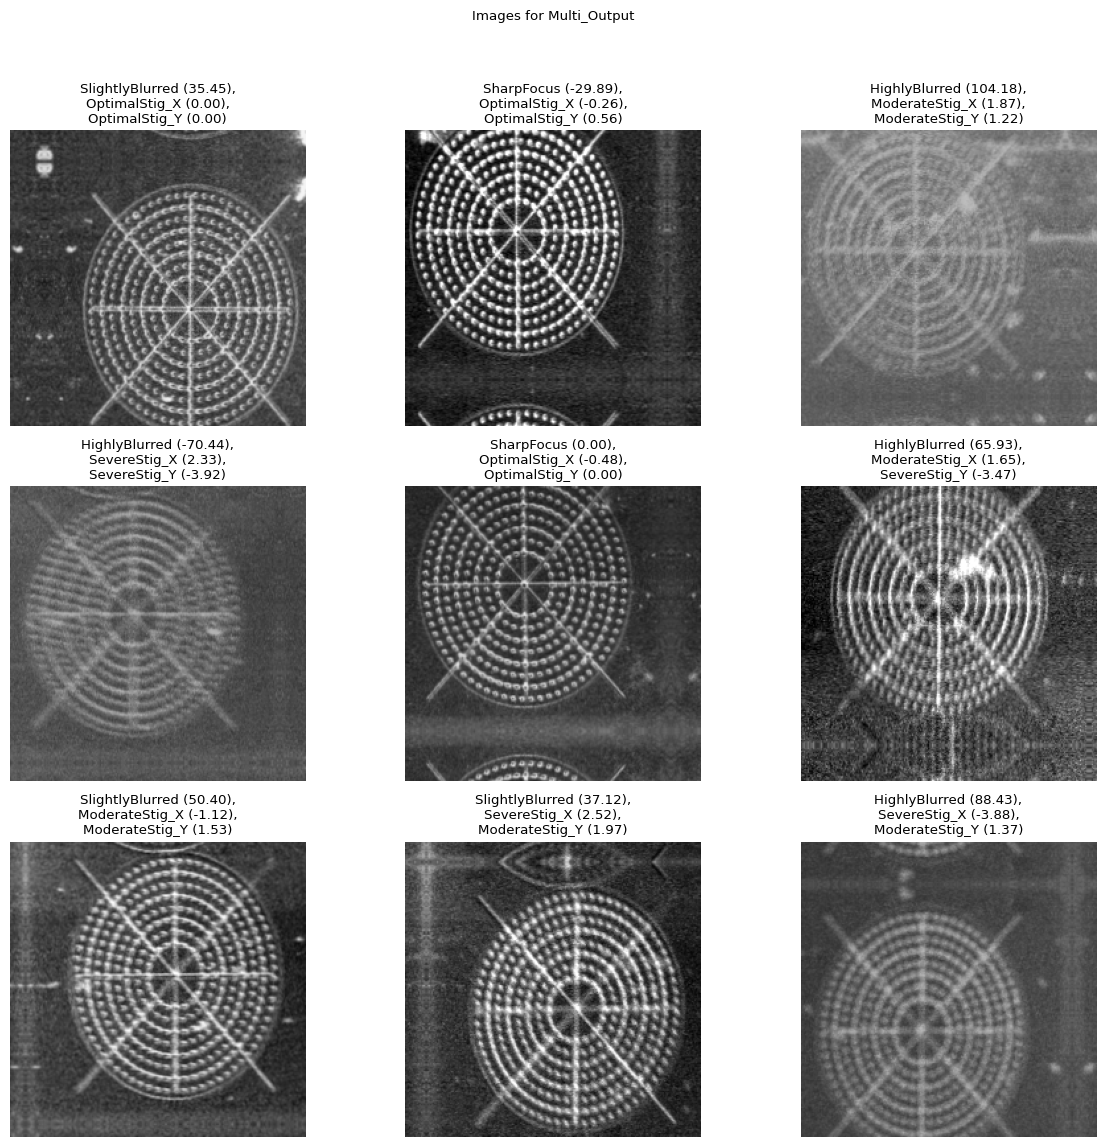

In [35]:
### Plot Images from Dataset

import textwrap
import matplotlib.pyplot as plt

def plot_single_image(ax, image, label_names, offsets):
    """
    Plots a single image with associated labels and offsets.
    """
    ax.imshow(image)
    title_text = ", ".join(f"{name} ({offset})" for name, offset in zip(label_names, offsets))
    ax.set_title("\n".join(textwrap.wrap(title_text, 30)))  # Wrap text to fit into the subplot
    ax.axis("off")

def extract_and_transform_labels(labels, label_keys, label_encoders):
    """
    Extracts and transforms labels using label encoders.
    """
    label_names = []
    for label_value, label_key in zip(labels, label_keys):
        label_encoder = label_encoders.get(label_key, None)
        if label_encoder:
            label_names.append(label_encoder.inverse_transform([label_value])[0])
        else:
            label_names.append(str(label_value))
    return label_names

def plot_images_from_dataset(label_encoders, config, datasets):
    """
    Plots images, labels, and offsets (if available) from the provided datasets.
    
    Args:
        label_encoders (dict): Dictionary of label encoders for each label key.
        config (dict): Configuration dictionary containing problem type and other parameters.
        datasets (dict): Dictionary of datasets, containing training data for each label key.
    """
    label_keys = ['Focus_Label', 'StigX_Label', 'StigY_Label']
    problem_type = config['Experiment']['PROBLEM_TYPE']

    plt.rcParams.update({'font.size': 8})
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    # Helper function to get relevant dataset based on problem type
    def get_relevant_dataset(problem_type, label_key):
        return datasets['train'][label_key if problem_type in ['Multi-Class', 'Binary'] else 'Multi_Output']

    # If problem type is not Multi-Output, re-use the same logic for both Binary and Multi-Class
    relevant_datasets = [label_keys] if problem_type != "Multi-Output" else ["Multi_Output"]

    for label_key in relevant_datasets:
        label_encoder = label_encoders.get(label_key, None)
        fig.suptitle(f"Images for {label_key}")

        for data in get_relevant_dataset(problem_type, label_key).take(1):
            images, labels = data[:2]
            offsets = data[2] if len(data) > 2 else None

            for i in range(min(len(images), 9)):
                ax = axes[i // 3, i % 3]
                current_labels = labels[i].numpy() if problem_type == "Multi-Output" else [labels[i].numpy()]
                current_offsets = offsets[i].numpy() if offsets is not None else ["N/A"] * len(label_keys)
                # Round offsets to 2 decimal places
                current_offsets = [f"{offset:.2f}" for offset in current_offsets]

                label_names = extract_and_transform_labels(current_labels, label_keys, label_encoders)
                plot_single_image(ax, images[i].numpy(), label_names, current_offsets)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    if problem_type not in ["Multi-Class", "Binary", "Multi-Output"]:
        print("Unknown problem type specified in config. Please check.")

# Example usage (assuming label_encoders, config, and datasets are defined elsewhere)
plot_images_from_dataset(label_encoders, config, datasets)


In [36]:
### Removing Offset Labels from the Dataset and Splitting (Doesn't Incorporate Changes from SIMv9)

def inspect_dataset_content(dataset, name, num_batches=3):
    """
    Inspect the content of the dataset to determine the nature of the tensors.
    """
    print(f"Inspecting first few records of {name} dataset...")
    
    for i, record in enumerate(dataset.take(num_batches)):
        summary = {k: (v.shape, v.dtype) for k, v in record.items()}
        print(f"{name} record {i + 1}: {summary}")
        
    print(f"Inspecting unique values in {name} dataset...")
    
    for i, batch in enumerate(dataset.take(num_batches)):
        print(f"Batch {i + 1} content:")
        
        for tensor_name, tensor in batch.items():
            unique_values = tf.unique(tf.reshape(tensor, [-1])).y.numpy()
            print(f"Unique values in {tensor_name}: {unique_values}")
        
        print("------")

def select_tensors(*tensors):
    return tensors[0], tensors[1]  # Return only the image and label tensors
    # return tensors[0], tensors[1], tensors[2]  # Return image, label, and offset tensors

def get_dataset(raw_datasets, dataset_type):
    """Retrieve specific dataset type (train, valid, test) from the raw datasets dictionary."""
    return raw_datasets.get(dataset_type, {}).get('Multi_Output')

def prepare_and_inspect_dataset(dataset, dataset_name):
    """Apply transformations and inspect a dataset."""
    if dataset is None:
        print(f"{dataset_name} dataset is None. Skipping.")
        return None

    dataset = dataset.map(select_tensors)
    # inspect_dataset_content(dataset, dataset_name)
    
    return dataset

def prepare_datasets_for_training(raw_datasets):
    """
    Prepare and inspect datasets for training.

    Returns:
    - A tuple containing prepared TensorFlow datasets for training, validation, and testing.
    """
    if raw_datasets is None:
        print("Datasets dictionary is None. Exiting.")
        return None, None, None

    train_dataset = prepare_and_inspect_dataset(get_dataset(raw_datasets, 'train'), 'Train')
    valid_dataset = prepare_and_inspect_dataset(get_dataset(raw_datasets, 'valid'), 'Validation')
    test_dataset = prepare_and_inspect_dataset(get_dataset(raw_datasets, 'test'), 'Test')
    
    return train_dataset, valid_dataset, test_dataset

# Uncomment this line to run the function with your datasets
train_dataset, valid_dataset, test_dataset = prepare_datasets_for_training(datasets)
# train_dataset, valid_dataset, test_dataset = prepare_datasets_for_training(resampled_datasets)


## Creating Classification Models

In [37]:
### Model Building (Define the Model)

def add_multi_output_heads(base_layer, num_classes: int, output_names: List[str]) -> List[keras.layers.Layer]:
    """Creates multiple output heads for a given base layer."""
    outputs = []
    for i in range(num_classes):
        x = layers.Dense(128, activation="relu")(base_layer)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(3, activation="softmax", name=output_names[i])(x)  # Naming each output layer
        outputs.append(x)
    return outputs

def determine_activation_and_units(num_classes: int) -> Tuple[List[str], List[int]]:
    """Determines the activation functions and units based on the number of classes and config settings."""
    problem_type = config.get('Experiment').get('PROBLEM_TYPE')
    if problem_type in ['Multi-Label', 'Binary', 'Multi-Class', 'Multi-Output']:
        return {
            'Multi-Label': (["sigmoid"] * num_classes, [1] * num_classes),
            'Binary': (["sigmoid"], [1]),
            'Multi-Class': (["softmax"], [num_classes]),
            'Multi-Output': (["softmax"] * num_classes, [3] * num_classes)  # Assuming each output has 3 classes
        }[problem_type]
    raise ValueError(f"Invalid problem_type: {problem_type}")

def create_transfer_model(base_model, input_shape: Tuple[int, int, int], num_classes: int, hidden_units: List[int], dropout_rate: float, regularizer_rate: float, output_names: List[str] = None) -> keras.Model:
    """Creates a transfer learning model based on the provided base model."""
    base_model.trainable = False
    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D()
    ])
    for units in hidden_units:
        model.add(layers.Dense(units, kernel_regularizer=keras.regularizers.l2(regularizer_rate), bias_regularizer=keras.regularizers.l2(regularizer_rate)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(dropout_rate))
    
    activations, units_list = determine_activation_and_units(num_classes)
    if len(activations) == 1:
        model.add(layers.Dense(units_list[0], activation=activations[0]))
        return model
    
    # output_names = output_names or list(config['Labels']['MAPPINGS'].keys())
    output_names = list(config['Labels']['MAPPINGS'].keys())

    outputs = add_multi_output_heads(model.layers[-1].output, num_classes, output_names)
    return keras.Model(inputs=model.input, outputs=outputs)

def create_specific_transfer_model(base_model_class, input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    """Helper function to create specific transfer models."""
    base_model = base_model_class(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001, output_names=config['Labels']['MAPPINGS'].keys())

def create_mobilenetv2_transfer_model(input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    return create_specific_transfer_model(tf.keras.applications.MobileNetV2, input_shape, num_classes)

def create_inceptionv3_transfer_model(input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    return create_specific_transfer_model(tf.keras.applications.InceptionV3, input_shape, num_classes)

def create_resnet50_transfer_model(input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    return create_specific_transfer_model(tf.keras.applications.ResNet50, input_shape, num_classes)

# Define the function to create a basic CNN model
def create_basic_cnn_model(input_shape, num_classes):
    conv2d_filter_size = (3, 3)
    conv2d_activation = 'relu'
    dense_activation = 'relu'
    num_conv_blocks = 3

    inputs = keras.Input(shape=input_shape)

    x = inputs

    for _ in range(num_conv_blocks):
        x = layers.Conv2D(32 * (2**_), conv2d_filter_size, activation=conv2d_activation, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation=dense_activation)(x)

    activations, units_list = determine_activation_and_units(num_classes)
    if len(activations) == 1:
        # Single output
        x = layers.Dense(units_list[0], activation=activations[0])(x)
        return keras.Model(inputs=inputs, outputs=x)
    else:
        # Multiple outputs
        outputs = add_multi_output_heads(x, num_classes, output_names=list(config['Labels']['MAPPINGS'].keys()))
        return keras.Model(inputs=inputs, outputs=outputs)

# Define the function to create a small version of the Xception network
def create_small_xception_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Entry block: Initial Convolution and BatchNormalization
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual for later use

    # Middle flow: Stacking Separable Convolution blocks
    for size in [256, 512, 728]:
        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Max Pooling
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual from previous block and add it to the current block
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Exit flow: Final Separable Convolution, BatchNormalization, and Global Average Pooling
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    activations, units_list = determine_activation_and_units(num_classes)
    if len(activations) == 1:
        # Single output
        x = layers.Dense(units_list[0], activation=activations[0])(x)
        return keras.Model(inputs=inputs, outputs=x)
    else:
        # Multiple outputs
        outputs = add_multi_output_heads(x, num_classes, output_names=list(config['Labels']['MAPPINGS'].keys()))
        return keras.Model(inputs=inputs, outputs=outputs)

# Model Selection function to select which model to use
def select_model(model_name: str, input_shape: Tuple[int, int, int], num_classes: int) -> keras.Model:
    """Selects a model to use based on the given model name."""
    model_map = {
        "mobilenetv2": create_mobilenetv2_transfer_model,
        "inceptionv3": create_inceptionv3_transfer_model,
        "resnet50": create_resnet50_transfer_model,
        "small_xception": create_small_xception_model,
        "basic_cnn": create_basic_cnn_model
    }
    if model_name not in model_map:
        raise ValueError("Invalid model name")

    return model_map[model_name](input_shape, num_classes)

In [38]:
### Model Initialization (Compile the Model)

# # Constants & Configurations
LOSS_CONFIG = {
    'Binary': 'binary_crossentropy',
    'Multi-Class': 'categorical_crossentropy',
    'Multi-Output': ['categorical_crossentropy'] * len(config['Labels']['MAPPINGS']),
    'Multi-Label': 'binary_crossentropy'
}

RECOMMENDED_METRICS = {
    'Binary': ['accuracy', 'binary_crossentropy', 'mean_squared_error'],
    'Multi-Class': ['categorical_accuracy', 'categorical_crossentropy', 'mean_squared_error'],
    'Multi-Output': ['categorical_accuracy'] * len(config['Labels']['MAPPINGS']) + 
                    ['categorical_crossentropy'] * len(config['Labels']['MAPPINGS']) + 
                    ['mean_squared_error'] * len(config['Labels']['MAPPINGS']),
    'Multi-Label': ['binary_accuracy', 'binary_crossentropy', 'mean_squared_error']
}

# Helper Functions
def get_accuracy_metric(problem_type: str) -> str:
    """Determine the accuracy metric based on the problem type."""
    return {'Binary': "accuracy", 'Multi-Label': "binary_accuracy"}.get(problem_type, "categorical_accuracy")

def create_directory(path: str):
    """Create a directory if it doesn't exist."""
    os.makedirs(path, exist_ok=True)

# Callback Setup Functions
def setup_common_callbacks() -> List[callbacks.Callback]:
    """Set up common callbacks."""
    return [
        callbacks.EarlyStopping(patience=config['Model']['EARLY_STOPPING_PATIENCE'], restore_best_weights=True),
        callbacks.ReduceLROnPlateau(patience=config['Model']['REDUCE_LR_PATIENCE'], min_lr=config['Model']['MIN_LR'])
    ]

def setup_specific_callbacks(model_name: str, model_dir: str, problem_type: str) -> List[callbacks.Callback]:
    """Set up model-specific callbacks."""
    datetime_str = datetime.now().strftime("%Y%m%d-%I%M%S%p")
    acc_metric = get_accuracy_metric(problem_type)
    checkpoint_path = os.path.join(model_dir, f"saved_model_{datetime_str}_epoch_{{epoch}}_val_loss_{{val_loss:.2f}}_{acc_metric}_{{{{val_{acc_metric}:.2f}}}}.h5")
    return [
        callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
        callbacks.TensorBoard(log_dir=os.path.join(model_dir, "logs", datetime_str))
    ]

def compile_model(model_name: str, input_shape: tuple, num_classes: int, problem_type: str) -> tf.keras.Model:
    """Compile and return a model."""
    model = select_model(model_name, input_shape, num_classes)
    metrics_to_use = list(set(RECOMMENDED_METRICS.get(problem_type, ['accuracy'])))
    loss_to_use = LOSS_CONFIG.get(problem_type, 'categorical_crossentropy')
    model.compile(
        optimizer=tf.keras.optimizers.Adam(config['Model']['LEARNING_RATE']), 
        loss=loss_to_use, 
        metrics=metrics_to_use
    )
    # model.summary()
    
    return model

def compile_and_initialize_models() -> Dict[str, Dict[str, tf.keras.Model]]:
    """Main function to compile and initialize models."""
    input_shape = (config['Model']['IMG_SIZE'], config['Model']['IMG_SIZE'], 3)
    num_classes = 3
    problem_type = config['Experiment']['PROBLEM_TYPE']

    experiment_name = config['Experiment']['NAME']
    base_dir = f"./{experiment_name}"
    create_directory(base_dir)

    common_callbacks = setup_common_callbacks()
    label_names = config['Labels']['MAPPINGS'].keys() if problem_type in ['Multi-Class', 'Multi-Output'] else ['']

    compiled_models = {}
    for label_name in label_names:
        label_dir = os.path.join(base_dir, label_name)
        create_directory(label_dir)

        for model_name in ['mobilenetv2', 'inceptionv3', 'resnet50', 'small_xception', 'basic_cnn']:
            model_dir = os.path.join(label_dir, model_name)
            create_directory(model_dir)
            
            specific_callbacks = setup_specific_callbacks(model_name, model_dir, problem_type)
            all_callbacks = common_callbacks + specific_callbacks
            
            model = compile_model(model_name, input_shape, num_classes, problem_type)
            compiled_models[model_name] = {'model': model, 'callbacks': all_callbacks}
    
    return compiled_models

# Execution
compiled_models = compile_and_initialize_models()
print("Models compiled and initialized successfully.")


Models compiled and initialized successfully.


In [39]:
### Investigating Model Outputs


for label_category, encoder in label_encoders.items():
    print(f'Mapping for {label_category}:')
    for index, class_label in enumerate(encoder.classes_):
        print(f'{index}: {class_label}')
    print()  # print a blank line between categories



def analyze_model_outputs(compiled_models, train_dataset):
    model_output_details = []
    
    # Assuming train_dataset is an iterable that yields batches of data,
    # We'll take the first batch of images from the training dataset for analysis.
    for images, labels in train_dataset.take(1):
        image_batch = images.numpy()  # Convert tensors to numpy arrays if necessary

    # Order of label encoders corresponding to the outputs
    encoder_order = ['Focus_Label', 'StigX_Label', 'StigY_Label']
    
    for model_name, model_details in compiled_models.items():
        model = model_details['model']
        output = model.predict(image_batch)
        
        if not isinstance(output, list):
            output = [output]  # Ensure output is a list for consistency
        
        for i, output_to_check in enumerate(output):
            one_hot_encoded = all((np.sum(row) > 0.99 and np.sum(row) < 1.01) for row in output_to_check)
            suggested_loss = 'categorical_crossentropy' if one_hot_encoded else 'sparse_categorical_crossentropy'
            max_prob_class = np.argmax(output_to_check, axis=-1)
            
            # Get the label encoder for the current output
            encoder_key = encoder_order[i] if i < len(encoder_order) else None
            label_encoder = label_encoders[encoder_key] if encoder_key else None
            
            # Decode the sample output
            sample_output = output_to_check[0] if len(output_to_check) > 0 else "No Output"
            sample_output_decoded = label_encoder.inverse_transform([np.argmax(sample_output)])[0] if label_encoder else "No Decoder"
            
            model_output_details.append({
                "Model Name": model_name,
                # Include Output Layer Name 
                "Output Layer Name": model.output_names[i],
                "Output": f'Output {i+1}',
                "Input Shape": model.input_shape,
                "Output Shape": output_to_check.shape,
                "Output Type": type(output).__name__,
                "Is One-Hot Encoded": one_hot_encoded,
                "Suggested Loss": suggested_loss,
                "Max Probability Class": max_prob_class,
                "Sample Output": sample_output,
                "Sample Output (Decoded)": sample_output_decoded
            })

    return pd.DataFrame(model_output_details).style.set_table_styles(
        [{"selector": "th", "props": [("font-size", "100%"), ("text-align", "center")]},
         {"selector": "td", "props": [("font-size", "100%"), ("text-align", "center")]}]
    )

# Assuming train_dataset is already defined and loaded with your training data
# Display the analysis
analyze_model_outputs(compiled_models, train_dataset)

Mapping for Focus_Label:
0: HighlyBlurred
1: SharpFocus
2: SlightlyBlurred

Mapping for StigX_Label:
0: ModerateStig_X
1: OptimalStig_X
2: SevereStig_X

Mapping for StigY_Label:
0: ModerateStig_Y
1: OptimalStig_Y
2: SevereStig_Y

1/1 [==============================] - 0s 128ms/step


,Model Name,Output Layer Name,Output,Input Shape,Output Shape,Output Type,Is One-Hot Encoded,Suggested Loss,Max Probability Class,Sample Output,Sample Output (Decoded)
0,mobilenetv2,Focus_Label,Output 1,"(None, 224, 224, 3)","(16, 3)",list,True,categorical_crossentropy,[2 2 2 2 2 2 2 1 1 2 2 1 1 1 2 2],[0.2031197 0.31396225 0.48291808],SlightlyBlurred
1,mobilenetv2,StigX_Label,Output 2,"(None, 224, 224, 3)","(16, 3)",list,True,categorical_crossentropy,[2 2 2 2 2 1 2 2 0 2 2 2 1 2 2 2],[0.25566772 0.2655855 0.47874674],SevereStig_X
2,mobilenetv2,StigY_Label,Output 3,"(None, 224, 224, 3)","(16, 3)",list,True,categorical_crossentropy,[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2],[0.17155305 0.2066678 0.62177914],SevereStig_Y
3,inceptionv3,Focus_Label,Output 1,"(None, 224, 224, 3)","(16, 3)",list,True,categorical_crossentropy,[0 0 2 2 0 2 0 1 0 0 2 1 0 0 1 0],[0.4159902 0.27180094 0.31220886],HighlyBlurred
4,inceptionv3,StigX_Label,Output 2,"(None, 224, 224, 3)","(16, 3)",list,True,categorical_crossentropy,[2 2 0 1 1 2 2 2 2 2 2 2 1 1 2 2],[0.21038643 0.379439 0.41017458],SevereStig_X
5,inceptionv3,StigY_Label,Output 3,"(None, 224, 224, 3)","(16, 3)",list,True,categorical_crossentropy,[2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2],[0.21449485 0.2982467 0.48725843],SevereStig_Y
6,resnet50,Focus_Label,Output 1,"(None, 224, 224, 3)","(16, 3)",list,True,categorical_crossentropy,[1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1],[0.25103605 0.3828519 0.36611208],SharpFocus
7,resnet50,StigX_Label,Output 2,"(None, 224, 224, 3)","(16, 3)",list,True,categorical_crossentropy,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1],[0.1263183 0.5197247 0.35395697],OptimalStig_X
8,resnet50,StigY_Label,Output 3,"(None, 224, 224, 3)","(16, 3)",list,True,categorical_crossentropy,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0],[0.51204044 0.19639729 0.2915623 ],ModerateStig_Y
9,small_xception,Focus_Label,Output 1,"(None, 224, 224, 3)","(16, 3)",list,True,categorical_crossentropy,[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2],[0.33333313 0.3333333 0.3333336 ],SlightlyBlurred


## Training Classification Models

In [40]:
### Prepare class weights for multi-output problems (Optional)

def prepare_class_weights_for_multi_output(info: pd.DataFrame) -> Union[Dict[str, Dict[int, float]], None]:
    """
    Prepare class weights for multi-output problems for Keras and TensorFlow.
    
    Parameters:
    - info: DataFrame containing the class weights information
    - config: Configuration dictionary.
    
    Returns:
    - Dictionary mapping output layer names to their respective class weight dictionaries or None
    """
    if not config.get('USE_CLASS_WEIGHTS', True):
        print("Configuration says not to use class weights. Returning None.")
        return None

    class_weights = {}
    for label in info.index.get_level_values('label').unique():
        class_weights[label] = {}
        sub_df = info.loc[(slice(None), label), :]
        for idx, row in sub_df.iterrows():
            class_idx = label_encoders[label].transform([idx[2]])[0]  # Transforming class name to class index
            class_weights[label][class_idx] = row['Weight']
    return class_weights

# Additions to the config
config['USE_CLASS_WEIGHTS'] = True  # Decide whether to use class weights or not
prepared_class_weights = prepare_class_weights_for_multi_output(df_class_weights)
# print(prepared_class_weights)

### Training Main Function

In [41]:
from tensorflow.keras import backend as K
import gc
import os
import pandas as pd


from tensorflow.keras.callbacks import Callback



def handle_memory_after_training(model):
    K.clear_session()
    del model
    gc.collect()



def train_and_save_metrics(train_dataset, valid_dataset, test_dataset, compiled_models, prepared_class_weights):
    if not all([train_dataset, valid_dataset, test_dataset]):
        print("One or more datasets are None. Exiting.")
        return

    for model_name, model_info in compiled_models.items():
        try:
            history = _process_single_model(model_name, model_info, train_dataset, valid_dataset, prepared_class_weights)
            if history is not None:
                # Construct the path for the CSV file
                csv_filename = f"{model_name}_metrics.csv"
                csv_path = os.path.join("./", csv_filename)
                # Convert history to DataFrame and save as CSV
                pd.DataFrame(history.history).to_csv(csv_path)
                print(f"Saved metrics for {model_name} to {csv_path}")
        except Exception as e:
            print(f"Error processing model {model_name}: {e}")
            continue

    print("\nFinished training all models.")

def _process_single_model(model_name, model_info, train_dataset, valid_dataset, prepared_class_weights):
    model = model_info.get('model')
    callbacks = model_info.get('callbacks', [])

    if model is None:
        print(f"Model for {model_name} is None. Skipping.")
        return None

    print(f"Training {model_name} for multi-output...")

    model_output_names = [layer.name for layer in model.layers if 'output' in layer.name]
    current_class_weights = {name: prepared_class_weights[name] for name in model_output_names}

    history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=config['Model']['EPOCHS'],
        callbacks=callbacks,
        class_weight=current_class_weights
    )

    handle_memory_after_training(model)

    print(f"\nTraining for {model_name} completed.")
    return history



# Assuming you've already defined and initialized all your datasets and configs
train_and_save_metrics(train_dataset, valid_dataset, test_dataset, compiled_models, prepared_class_weights)


Training mobilenetv2 for multi-output...
Epoch 1/100
961/961 [==============================] - 749s 774ms/step - loss: 10.2505 - Focus_Label_loss: 3.3439 - StigX_Label_loss: 3.3331 - StigY_Label_loss: 3.3318 - Focus_Label_mean_squared_error: 0.9141 - Focus_Label_categorical_crossentropy: 3.3439 - Focus_Label_categorical_accuracy: 0.4587 - StigX_Label_mean_squared_error: 0.9124 - StigX_Label_categorical_crossentropy: 3.3331 - StigX_Label_categorical_accuracy: 0.4855 - StigY_Label_mean_squared_error: 0.9129 - StigY_Label_categorical_crossentropy: 3.3318 - StigY_Label_categorical_accuracy: 0.4624 - val_loss: 9.7743 - val_Focus_Label_loss: 3.1936 - val_StigX_Label_loss: 3.1955 - val_StigY_Label_loss: 3.1936 - val_Focus_Label_mean_squared_error: 0.8901 - val_Focus_Label_categorical_crossentropy: 3.1936 - val_Focus_Label_categorical_accuracy: 0.7147 - val_StigX_Label_mean_squared_error: 0.8902 - val_StigX_Label_categorical_crossentropy: 3.1955 - val_StigX_Label_categorical_accuracy: 0.7184 

Mixed Precision Training: This involves using a mix of float16 and float32 data types during training to reduce memory usage and speed up training. Modern GPUs are optimized for float16 arithmetic, so this can lead to significant speedups as well.

Check Other GPU Processes: Ensure that no other processes are using the GPU memory. Use the nvidia-smi command to check GPU memory usage. If other processes are running on the GPU, consider stopping them or moving your training to another time.

Free Up GPU Memory: Ensure that any previous models or tensors that you no longer need are deleted and that you've called tf.keras.backend.clear_session() to clear any remnants from the GPU memory.

## Evaluating Classification Models

KeyError: 'Focus_Label_loss'

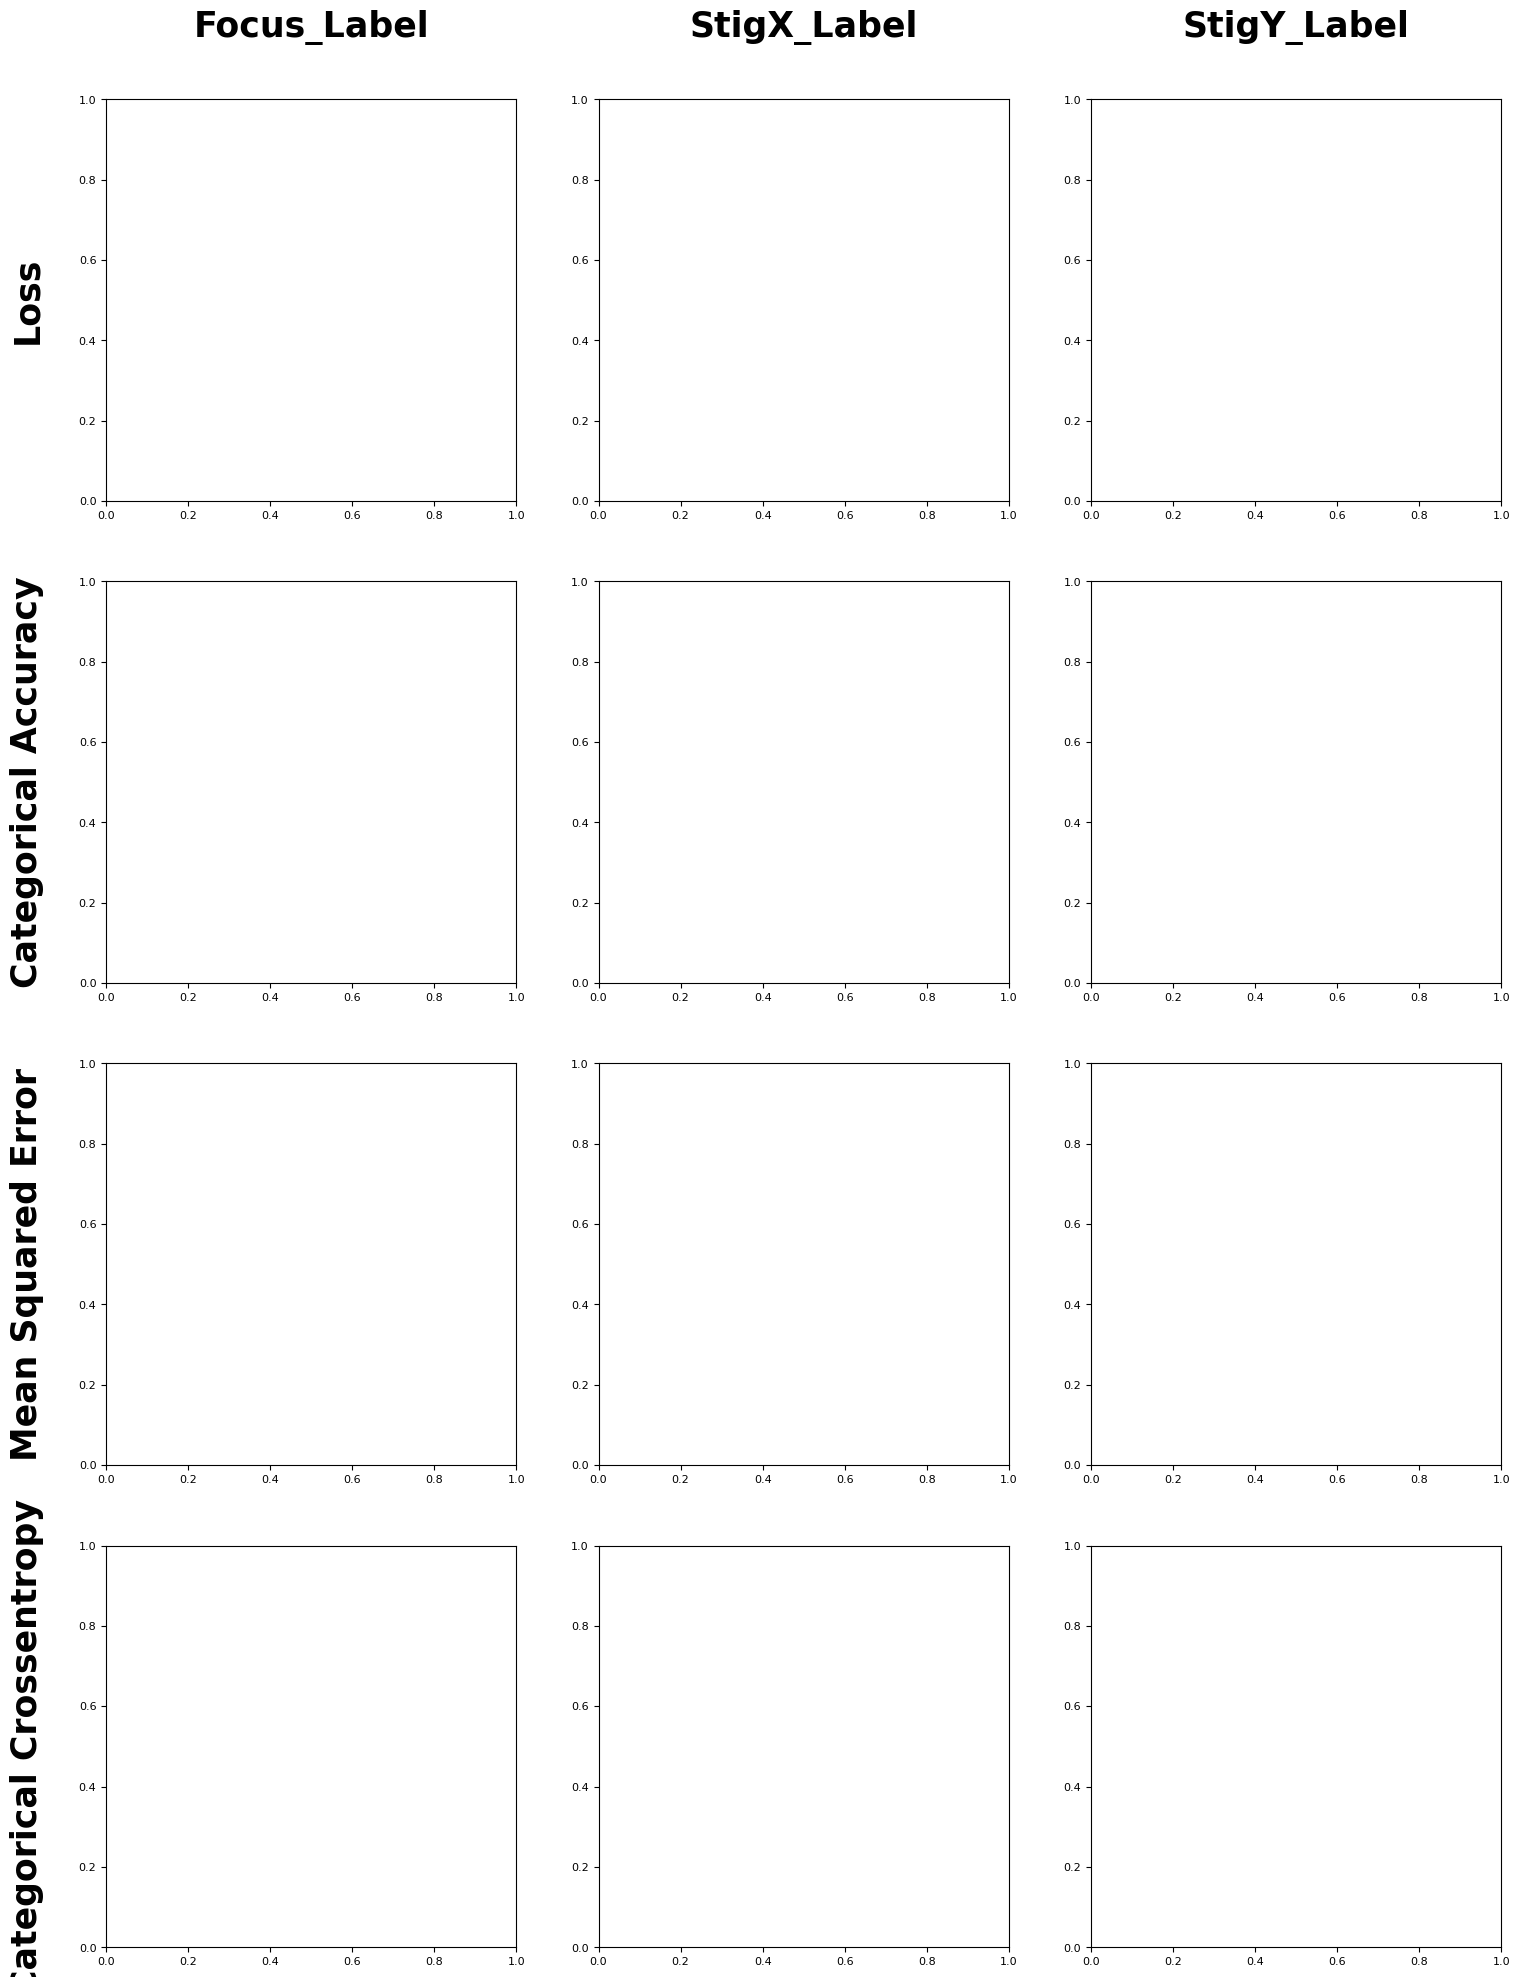

In [42]:
# Define all the necessary functions and classes from the provided code


# Now, execute the function and plot the metrics using the uploaded Excel file
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple

# Custom handler for vertical legend tuples
class HandlerTupleVertical(HandlerTuple):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()
        height_y = (height / numlines)
        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)
            legline = handler.create_artists(legend, handle, xdescent, (2*i + 1)*height_y, width, 2*height, fontsize, trans)
            leglines.extend(legline)
        return leglines

# Global variables
MODEL_NAME_MAPPING = {
    "mobilenetv2": "MobileNetV2 Transfer",
    "inceptionv3": "InceptionV3 Transfer",
    "resnet50": "ResNet50 Transfer",
    "small_xception": "Small Xception",
    "basic_cnn": "Basic CNN"
}
LABELS = ['Focus_Label', 'StigX_Label', 'StigY_Label']
METRICS = ['loss', 'categorical_accuracy', 'mean_squared_error', 'categorical_crossentropy']

# Data processing utilities
def get_metrics_from_dataframe(df):
    return [col for col in METRICS if any(f"{label}_{col}" in df for label in LABELS)]

def get_dataframes_from_excel(xls):
    model_names = xls.sheet_names
    return {model_name: pd.read_excel(xls, model_name) for model_name in model_names}

def get_readable_metric_name(metric):
    mapping = {
        'loss': 'Loss',
        'categorical_accuracy': 'Categorical Accuracy',
        'categorical_crossentropy': 'Categorical Crossentropy',
        'mean_squared_error': 'Mean Squared Error'
    }
    return mapping.get(metric, metric.capitalize())

def moving_average(data, window_size):
    """Compute the moving average of a dataset."""
    return data.rolling(window=window_size).mean()

def publication_ready_plot(excel_path, epoch_range=None, smoothing_window=None):
    """Generate a truly publication-ready grid of plots with all adjustments."""
    # Load data
    xls = pd.ExcelFile(excel_path)
    dfs = get_dataframes_from_excel(xls)
    metrics = get_metrics_from_dataframe(next(iter(dfs.values())))
    
    # Set up color dictionary for models
    model_names = dfs.keys()
    readable_model_names = [MODEL_NAME_MAPPING.get(name, name) for name in model_names]
    model_palette = sns.color_palette("tab10", len(model_names))
    model_color_dict = {readable_name: model_palette[i] for i, readable_name in enumerate(readable_model_names)}
    
    # Create the grid of plots with adjusted settings
    fig, axes = plt.subplots(len(metrics), len(LABELS), figsize=(18, 18 * len(metrics)/len(LABELS)))
    
    # Titles for columns and rows with enhanced font settings
    for j, label in enumerate(LABELS):
        axes[0, j].set_title(label, fontsize=25, fontweight='bold', pad=45)
    for i, metric in enumerate(metrics):
        axes[i, 0].set_ylabel(get_readable_metric_name(metric), fontsize=25, fontweight='bold', labelpad=25)
    
    for i, metric in enumerate(metrics):
        # Enhanced y-limits calculation using percentiles to avoid extreme outliers
        all_values = [value for df in dfs.values() for label in LABELS for value in df[f'{label}_{metric}'].tolist() + df[f'val_{label}_{metric}'].tolist()]
        lower_bound = np.percentile(all_values, 5)
        upper_bound = np.percentile(all_values, 90)
        buffer = (upper_bound - lower_bound) * 0.5  
        
        for j, label in enumerate(LABELS):
            ax = axes[i, j]
            ax.set_ylim(lower_bound - buffer, upper_bound + buffer)
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
            
            # Optional epoch range
            if epoch_range:
                ax.set_xlim(epoch_range)
            
            # Declutter y-axis and enhance font settings
            if j != 0:
                ax.set_yticklabels([])
            else:
                ax.tick_params(axis='y', labelsize=18)
            # Declutter x-axis and enhance font settings
            if i != len(metrics) - 1:
                ax.set_xticklabels([])
            else:
                ax.tick_params(axis='x', labelsize=18)
                ax.set_xlabel('Epoch', fontsize=20)
            
            for model_name, df in dfs.items():
                readable_model_name = MODEL_NAME_MAPPING.get(model_name, model_name)
                color = model_color_dict[readable_model_name]
                
                # Apply smoothing if specified
                if smoothing_window:
                    train_data = moving_average(df[f'{label}_{metric}'], smoothing_window)
                    val_data = moving_average(df[f'val_{label}_{metric}'], smoothing_window)
                else:
                    train_data = df[f'{label}_{metric}']
                    val_data = df[f'val_{label}_{metric}']
                
                # Plot training data with enhanced line width
                ax.plot(df['epoch'], train_data, '--', color=color, label=f"{readable_model_name}", linewidth=3)
                
                # Plot validation data with enhanced line width
                ax.plot(df['epoch'], val_data, '-', color=color, label=f"{readable_model_name} (Validation)", linewidth=3)
    
    # Handle legend with enhanced font settings
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [(handles[j], handles[j + 1]) for j in range(0, len(handles), 2)]
    fig.legend(new_handles, labels[::2], handler_map={tuple: HandlerTupleVertical()}, loc="lower center", 
               borderaxespad=0.1, ncol=len(dfs), fontsize=15, frameon=True, bbox_to_anchor=(0.5, 0.02))


    # Adjust layout and add a title for the entire figure
    fig.tight_layout()
    fig.subplots_adjust(top=0.93, bottom=0.10)  # Adjust the layout to make space for the legend
    fig.suptitle('Model Metrics Comparison', fontsize=30, fontweight='bold', y=1.03)
    
    plt.show()
    
excel_path = 'Oct9_100pct_CW_SIM.xlsx'
# Generate the truly publication-ready plot with optional smoothing and epoch range
publication_ready_plot(excel_path, epoch_range=(5, 70), smoothing_window=5)



In [ ]:
### Comparing Experiment Results (Refactored GraphVersion)

# Constants
FILE_PATHS = [
    "SIM_Unbalanced.xlsx",
    "V9_Laptop - Multi-Output.xlsx",
    "V9.1_Laptop - Multi-Output.xlsx",
]

METRIC_VISUALIZATION_KEYS_WITH_EPOCHS = [
    (
        "Max Validation Categorical Accuracy",
        "Max Validation Categorical Accuracy Across Experiments",
        "Epoch at Max Validation Categorical Accuracy",
    ),
    (
        "Min Validation Loss",
        "Min Validation Loss Across Experiments",
        "Epoch at Min Validation Loss",
    ),
    (
        "Min Validation Categorical Crossentropy",
        "Min Validation Categorical Crossentropy Across Experiments",
        "Epoch at Min Validation Categorical Crossentropy",
    ),
    (
        "Min Validation Mean Squared Error",
        "Min Validation Mean Squared Error Across Experiments",
        "Epoch at Min Validation Mean Squared Error",
    ),
]

def extract_key_metrics_updated(excel_path):
    """Extract key metrics from the provided Excel file without using determine_engine."""
    # Load the Excel file and get DataFrames
    xls = pd.ExcelFile(excel_path, engine="openpyxl")
    dfs = get_dataframes_from_excel(xls)

    return {
        model_name: {
            "Min Validation Loss": df["val_loss"].min(),
            "Epoch at Min Validation Loss": df["epoch"].iloc[
                df["val_loss"].idxmin()
            ],
            "Max Validation Categorical Accuracy": df[
                "val_categorical_accuracy"
            ].max(),
            "Epoch at Max Validation Categorical Accuracy": df["epoch"].iloc[
                df["val_categorical_accuracy"].idxmax()
            ],
            "Min Validation Categorical Crossentropy": df[
                "val_categorical_crossentropy"
            ].min(),
            "Epoch at Min Validation Categorical Crossentropy": df[
                "epoch"
            ].iloc[df["val_categorical_crossentropy"].idxmin()],
            "Min Validation Mean Squared Error": df[
                "val_mean_squared_error"
            ].min(),
            "Epoch at Min Validation Mean Squared Error": df["epoch"].iloc[
                df["val_mean_squared_error"].idxmin()
            ],
        }
        for model_name, df in dfs.items()
    }


def extract_and_map_metrics(excel_path, name_mapping, metric_key, epoch_key):
    """Extract and map metrics using the provided name mapping."""
    experiment_name = os.path.basename(excel_path).replace(".xlsx", "")
    metrics = extract_key_metrics_updated(excel_path)

    # Use the name_mapping to rename models
    mapped_metric_values = {
        name_mapping.get(model, model): data[metric_key] for model, data in metrics.items()
    }
    mapped_epoch_values = {
        name_mapping.get(model, model): data[epoch_key] for model, data in metrics.items()
    }

    return experiment_name, mapped_metric_values, mapped_epoch_values


def visualize_mapped_metrics(metric_data, epoch_data, metric_title, metric_key):
    """Visualize a specific metric across experiments and annotate bars with epoch numbers."""
    metric_df = pd.DataFrame(metric_data).transpose()

    # Create the plot
    plt.figure(figsize=(15, 10))
    ax = metric_df.plot(kind="bar", ax=plt.gca(), colormap="viridis")
    plt.title(metric_title, fontsize=18)
    plt.ylabel(metric_key, fontsize=16)
    plt.xlabel("Experiment", fontsize=16)
    plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    ax.grid(axis='y')
    
    # Annotate bars with epoch numbers
    for idx, rect in enumerate(ax.patches):
        experiment_idx = idx // len(metric_df.columns)
        model_idx = idx % len(metric_df.columns)
        experiment_name = metric_df.index[experiment_idx]
        model_name = metric_df.columns[model_idx]
        epoch_value = epoch_data[experiment_name][model_name]
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height(), f'Ep {epoch_value}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()


def main_visualization(file_paths, name_mapping, metric_visualization_keys_with_epochs):
    """Main function for visualization."""
    for metric_key, metric_title, epoch_key in metric_visualization_keys_with_epochs:
        metric_data = {}
        epoch_data = {}

        for excel_path in file_paths:
            experiment_name, mapped_metric_values, mapped_epoch_values = extract_and_map_metrics(
                excel_path, name_mapping, metric_key, epoch_key
            )
            metric_data[experiment_name] = mapped_metric_values
            epoch_data[experiment_name] = mapped_epoch_values

        visualize_mapped_metrics(metric_data, epoch_data, metric_title, metric_key)


# Execute the main function
main_visualization(
    FILE_PATHS, model_name_mapping, METRIC_VISUALIZATION_KEYS_WITH_EPOCHS
)

NameError: name 'model_name_mapping' is not defined

## Loading and Testing Classification Models

In [ ]:
### Loading the Best Model from Directories

def get_best_model_filename(directory):
    """Identify the best model filename based on the minimum validation loss from the directory."""
    model_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
    if not model_files:
        print(f"No model files found in {directory}")
        return None
    return min(model_files, key=lambda x: float(x.split('val_loss_')[1].split('_')[0]))

def load_best_model(directory):
    """Loads the best model from the specified directory."""
    best_model_file = get_best_model_filename(directory)
    if not best_model_file:
        return None
    best_model_path = os.path.join(directory, best_model_file)
    # return load_model(best_model_path)
    return load_model(best_model_path, compile=False)

def get_label_directories(experiment_directory):
    """Determine label directories or just model directories in the experiment directory."""
    first_level_dirs = [os.path.join(experiment_directory, d) for d in os.listdir(experiment_directory) 
                        if os.path.isdir(os.path.join(experiment_directory, d))]
    if any('mobilenetv2' in dir_name for dir_name in first_level_dirs):
        return [experiment_directory]
    return first_level_dirs

def load_all_best_models(experiment_directory):
    """Load the best model for each model type within the experiment directory."""
    best_models = {}
    label_dirs = get_label_directories(experiment_directory)
    for label_dir in label_dirs:
        for model_name in ['mobilenetv2', 'inceptionv3', 'resnet50', 'small_xception', 'basic_cnn']:
            model_dir = os.path.join(label_dir, model_name)
            best_model = load_best_model(model_dir)
            if best_model:
                key_name = f"{os.path.basename(label_dir)}_{model_name}"
                best_models[key_name] = best_model
    return best_models

# Example Usage
experiment_directory = "SIM_Unbalanced"
all_best_models = load_all_best_models(experiment_directory)
print(all_best_models.keys())  # This will display the keys of the loaded models.

## Investigating and Debugging

In [ ]:
### Displaying Model Outputs in a Table (Refactored GraphVersion)

from tabulate import tabulate

def predict_with_model(model, sample_input):
    """Predict the output using the given model and input."""
    output = model.predict(sample_input)
    
    # Convert TensorFlow tensor to numpy array if needed
    if hasattr(output, 'numpy'):
        output = output.numpy()
    
    return output

def capture_model_output_details(model_name, model, sample_input):
    """Capture details of model's output for a given input."""
    output = predict_with_model(model, sample_input)
    return {
        "Model Name": model_name,
        "Input Shape": model.input_shape,
        "Output Shape": output.shape,
        "Output Type": type(output).__name__,
        "Sample Output": output[0] if len(output) > 0 else "No Output"
    }

def display_model_outputs_in_table(all_best_models, sample_input):
    """Display details of model's outputs in a tabular format."""
    model_output_details = [capture_model_output_details(model_name, model, sample_input) 
                            for model_name, model in all_best_models.items()]
    
    print(tabulate(model_output_details, headers="keys", tablefmt="grid"))

# Sample Usage
sample_input = test_images
display_model_outputs_in_table(all_best_models, sample_input)


In [ ]:
### Inspecting the first few samples from the test dataset (Refactored GraphVersion)

def inspect_test_samples(test_dataset, label_encoders, num_samples_to_inspect=3):
    """
    Inspect a specified number of samples from a test dataset.
    
    Args:
    - test_dataset (tf.data.Dataset): The test dataset to inspect.
    - label_encoders (dict): A dictionary of label encoders.
    - num_samples_to_inspect (int, optional): Number of samples to inspect. Defaults to 3.
    
    Returns:
    - df: Styled DataFrame with inspected samples.
    """
    
    # Load a batch of test images, labels, and offset values
    test_images, test_labels_list, test_offsets = next(iter(test_dataset.take(1)))
    # test_images, test_labels_list = next(iter(test_dataset.take(1)))
    test_labels_array = np.stack([np.array(label) for label in test_labels_list])

    # Prepare data for DataFrame
    data = []
    for i in range(num_samples_to_inspect):
        sample_data = {
            "Sample": i + 1,
            "Image shape": str(test_images[i].shape),
            "Image values (first few)": f"{str(test_images[i].numpy().flatten()[:10])}...",
            "Labels shape": str(test_labels_array[i].shape),
            "Labels values": str(test_labels_array[i]),
        }

        for label, value in zip(label_encoders.keys(), test_labels_array[i]):
            sample_data[f"{label} (Decoded)"] = label_encoders[label].inverse_transform([value])[0]

        data.append(sample_data)

    # Create and display DataFrame
    df = pd.DataFrame(data).set_index("Sample")
    return df.style.hide_index()

# Sample Usage
styled_df = inspect_test_samples(train_dataset, label_encoders)
display(styled_df)

In [ ]:
### Displaying Images from the Test Dataset (Refactored GraphVersion)

import numpy as np
import matplotlib.pyplot as plt

def decode_single_label(value, label, label_encoders):
    """Decode a single label."""
    decoded_label = label_encoders[label].inverse_transform([value])[0]
    
    simple_mappings = {
        'SharpFocus': 'Optimal',
        'SlightlyBlurred': 'Moderate',
        'HighlyBlurred': 'Severe',
        'OptimalStig_X': 'Optimal',
        'ModerateStig_X': 'Moderate',
        'SevereStig_X': 'Severe',
        'OptimalStig_Y': 'Optimal',
        'ModerateStig_Y': 'Moderate',
        'SevereStig_Y': 'Severe'
    }
    
    return simple_mappings.get(decoded_label, decoded_label)

def decode_labels(encoded_labels, label_encoders):
    """Decode a set of labels."""
    return [decode_single_label(value, label, label_encoders) for label, value in zip(label_encoders.keys(), encoded_labels)]

def format_label_for_display(label, value, offset):
    """Format the label for display on the image."""
    label = label.replace("_Label", "").replace("StigX", "Astigmatism (X direction)").replace("StigY", "Astigmatism (Y direction)")
    return f"{label}: {value} (Offset: {offset:.2f})"

def display_samples_with_labels(images, decoded_labels, offsets):
    """Display images with their decoded labels."""
    num_samples_to_display = min(3, len(images))
    fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 5))
    for img, labels, offset, ax in zip(images[:num_samples_to_display], 
                                       decoded_labels[:num_samples_to_display], 
                                       offsets[:num_samples_to_display], 
                                       axes):
        ax.imshow(img.numpy())
        formatted_title = [format_label_for_display(label, value, off) for label, value, off in zip(label_encoders.keys(), labels, offset.numpy())]
        ax.set_title("\n".join(formatted_title))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Decode the labels of the test samples
test_images, test_labels_list, test_offsets = next(iter(test_dataset.take(1)))
# test_images, test_labels_list = next(iter(test_dataset.take(1)))

test_labels_array = np.stack([np.array(label) for label in test_labels_list])
decoded_labels = [decode_labels(labels, label_encoders) for labels in test_labels_array]

# Display the test samples
display_samples_with_labels(test_images, decoded_labels, test_offsets)


In [ ]:
### Showing True Labels for Test Samples (Refactored GraphVersion)

def format_column_name(column_name):
    """Format the column name."""
    return column_name.replace("_Label", "").replace("StigX", "Astigmatism (X direction)").replace("StigY", "Astigmatism (Y direction)")

def format_row_data(labels, offsets, label_encoders):
    """Format the row data."""
    return [f"{label} (Offset: {offset:.2f})" for label, offset, column_name in zip(labels, offsets, label_encoders.keys())]

def style_dataframe(df):
    """Style the DataFrame for a nicer display."""
    return df.style.set_table_styles(
        [
            {"selector": "th", "props": [("font-size", "100%"), ("text-align", "center")]},
            {"selector": "td", "props": [("font-size", "100%"), ("text-align", "center")]}
        ]
    )

# Decode labels and extract offsets
decoded_labels = [decode_labels(labels, label_encoders) for labels in test_labels_array]
offsets_list = [list(offset.numpy()) for offset in test_offsets]

# Prepare data and columns for DataFrame
data = [format_row_data(labels, offsets, label_encoders) for labels, offsets in zip(decoded_labels, offsets_list)]
columns = [format_column_name(column_name) for column_name in label_encoders.keys()]

# Create and style DataFrame
df = pd.DataFrame(data, columns=columns)
styled_df = style_dataframe(df)

styled_df


## Beta Testing

In [ ]:
# Graph Version Code for Confusion Matrix

from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, encoder=None, figsize=(10, 10), text_size=15, norm=False, savefig=False, output_num=None):
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels.

    Args:
    y_true: Array of truth labels.
    y_pred: Array of predicted labels.
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    encoder: Fitted LabelEncoder to transform integer labels back to original string labels.
    ... (other arguments as before)

    Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
    """
    
    # Error handling for array shapes
    if y_true.shape != y_pred.shape:
        print(f"Error: Mismatch in shapes of y_true ({y_true.shape}) and y_pred ({y_pred.shape}). Skipping this output.")
        return
    
    if encoder:
        y_true = encoder.inverse_transform(y_true)
        y_pred = encoder.inverse_transform(y_pred)
    
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    labels = classes if classes else np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        text = f"{cm[i, j]}" if not norm else f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)"
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, text, horizontalalignment="center", color=color, size=text_size)

    # Save the figure to the current working directory
    if savefig and output_num is not None:
        fig.savefig(f"confusion_matrix_output_{output_num + 1}.png")




def make_confusion_matrix_multi_output(y_true, y_preds, classes=None, encoders=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels for multi-output models.

    Args:
    y_true: 2D array of truth labels for multiple outputs.
    y_preds: 2D array of predicted labels for multiple outputs.
    classes: List of arrays of class labels (e.g. string form) for each output. If `None`, integer labels are used.
    encoders: List of fitted LabelEncoders to transform integer labels back to original string labels for each output.
    ... (other arguments as before)

    Returns:
    A list of labelled confusion matrix plots comparing y_true and y_preds for each output.
    """
    
    # Error handling for array shapes
    if y_true.shape != y_preds.shape:
        print(f"Error: Mismatch in shapes of y_true ({y_true.shape}) and y_preds ({y_preds.shape}). Cannot proceed.")
        return
    
    num_outputs = y_true.shape[1]
    
    for i in range(num_outputs):
        print(f"Confusion Matrix for Output {i + 1}:")
        encoder = encoders[i] if encoders else None
        make_confusion_matrix(y_true[:, i], np.argmax(y_preds[:, i], axis=1), classes[i] if classes else None, encoder, figsize, text_size, norm, savefig, i)
        plt.show()


In [ ]:
### Function for Confusion Matrix

def make_confusion_matrix_multi_output(y_true, y_preds, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels for multi-output models.

    Args:
    y_true: List of arrays of truth labels (must be same shape as y_preds).
    y_preds: List of arrays of predicted labels (must be same shape as y_true).
    classes: List of arrays of class labels (e.g. string form). If `None`, integer labels are used.
    ... (other arguments as before)

    Returns:
    A list of labelled confusion matrix plots comparing y_true and y_preds for each output.
    """
    # Check if y_true and y_preds are lists, if not, convert them to lists (for single-output compatibility)
    if not isinstance(y_true, list):
        y_true = [y_true]
    if not isinstance(y_preds, list):
        y_preds = [y_preds]
    
    for i, (true, pred) in enumerate(zip(y_true, y_preds)):
        print(f"Output {i + 1}:")
        make_confusion_matrix(true, pred, classes[i] if classes else None, figsize, text_size, norm, savefig)
        plt.show()

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # (The function content remains the same as you provided)

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    labels = classes if classes else np.arange(cm.shape[0])
    
    # Label the axes
    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
                     horizontalalignment="center",
                     color="white" if cm[i, j] > threshold else "black",
                     size=text_size)

    # Save the figure to the current working directory
    if savefig:
        fig.savefig(f"confusion_matrix_output_{i + 1}.png")
        
        
        
### Attempt at Using the Confusion Matrix Function

def extract_labels_from_dataset(dataset, problem_type):
    """
    Extract labels from a TensorFlow dataset based on the problem type.
    
    Args:
    - dataset (tf.data.Dataset): The TensorFlow dataset to extract labels from.
    - problem_type (str): The type of problem ('Multi-Output', 'Multi-Class', or 'Binary').
    
    Returns:
    - numpy array or dict: If 'Multi-Output', returns a numpy array with shape (num_samples, num_outputs).
                           If 'Multi-Class' or 'Binary', returns a dictionary with label types as keys and 
                           arrays of labels as values.
    """
    
    if problem_type == 'Multi-Output':
        labels_list = [labels for _, labels in dataset]
        return np.array(labels_list).squeeze()

    elif problem_type in ['Multi-Class', 'Binary']:
        labels_dict = {}
        for label_type in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
            label_data = []
            for _, labels in dataset[label_type]:
                label_data.extend(labels.numpy())
            labels_dict[label_type] = np.array(label_data)
        return labels_dict

    else:
        print(f"Unknown problem type: {problem_type}")
        return None

# Usage
problem_type = config['Experiment']['PROBLEM_TYPE']
test_labels = extract_labels_from_dataset(test_dataset, problem_type)

# Choose a specific model (replace 'specific_model_name' with the actual model name you're interested in)
model_name = 'specific_model_name'
model = all_best_models[model_name]

if not model:
    print(f"No model found for {model_name}")
    exit()

# 1. Predict on the test data
predictions = model.predict(test_dataset)


# 2. Get true labels and predictions for each output
# Assuming test_labels is a list where each item is an array of true labels for a given output
true_labels = [test_labels[i] for i in range(len(predictions))]
predicted_labels = [np.argmax(predictions[i], axis=1) for i in range(len(predictions))]

# List of class names for each output, assuming they are the same for all outputs in this example
classes_list = [list(range(3)) for _ in range(len(predictions))]

# 3. Generate confusion matrices
make_confusion_matrix_multi_output(true_labels, predicted_labels, classes_list)


## Incorporate Later

In [ ]:
def display_labels_with_probabilities(decoded_labels, probabilities):
    """
    Construct display strings that combine decoded labels with their corresponding probabilities.
    
    Parameters:
    - decoded_labels: A list of decoded label strings.
    - probabilities: A list of probability values corresponding to the decoded labels.
    
    Returns:
    - A list of strings combining labels with their probabilities.
    """
    return [f"{label} ({prob:.2f})" for label, prob in zip(decoded_labels, list(probabilities))]

# Load a batch of test images and labels
test_images, test_labels_list = next(iter(test_dataset.take(1)))
test_labels_array = np.stack([np.array(label) for label in test_labels_list])

# Make predictions using the selected model
predictions = model.predict(test_images)

# Decode the labels of the first few samples
decoded_labels = [decode_labels(labels, label_encoders) for labels in test_labels_array]
# Extract probabilities for the predicted labels
predicted_probs = [predictions[i][np.argmax(predictions[i])] for i in range(predictions.shape[0])]
display_strings = [display_labels_with_probabilities(labels, probs) for labels, probs in zip(decoded_labels, predicted_probs)]

# Display the images along with their decoded labels and probabilities
num_samples_to_display = 3
fig, axes = plt.subplots(1, num_samples_to_display, figsize=(15, 5))
for img, labels_with_probs, ax in zip(test_images[:num_samples_to_display], display_strings[:num_samples_to_display], axes):
    ax.imshow(img)
    title = "\n".join(labels_with_probs)
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Print the classification report
print(classification_report(y_labels, pred_classes))

# Note on classification_report():
# - Precision: Proportion of true positives. Higher precision -> fewer false positives.
# - Recall: Proportion of true positives over actual positives. Higher recall -> fewer false negatives.
# - F1 score: Harmonic mean of precision and recall. Range: [0, 1].

# Convert the report to a dictionary for further processing
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

# Focusing on f1-score as it combines precision and recall, extract it into a new dictionary
class_f1_scores = {class_names[int(k)]: v["f1-score"] for k, v in classification_report_dict.items() if k != "accuracy"}

class_f1_scores

# Convert dictionary to DataFrame and sort by f1-score in descending order
f1_scores_df = pd.DataFrame({
    "class_name": class_f1_scores.keys(),
    "f1-score": class_f1_scores.values()
}).sort_values("f1-score", ascending=False)

# Visualize f1-scores using a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 25))
bars = ax.barh(f1_scores_df["class_name"], f1_scores_df["f1-score"])
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for Different Classes")
ax.invert_yaxis()  # Reverse order for clarity

# Annotate bars with their respective scores
for bar in bars:
    ax.text(bar.get_width() * 1.03, bar.get_y() + bar.get_height() / 1.5,
            f"{bar.get_width():.2f}", ha='center', va='bottom')


In [ ]:
# Analyzing Most Wrong Predictions:
# Observing predictions with high confidence but incorrect can provide insights into model performance.
# Steps:
# 1. Get test image filepaths.
# 2. Create a DataFrame for image details and predictions.
# 3. Identify correct predictions.
# 4. Extract top 100 most confidently incorrect predictions.
# 5. Visualize some of the most wrong examples.

# 1. Get the filenames of all test data
filepaths = [filepath.numpy() for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False)]

# 2. Create a dataframe for prediction analysis
import pandas as pd
pred_df = pd.DataFrame({
    "img_path": filepaths,
    "y_true": y_labels,
    "y_pred": pred_classes,
    "pred_conf": pred_probs.max(axis=1),
    "y_true_classname": [class_names[i] for i in y_labels],
    "y_pred_classname": [class_names[i] for i in pred_classes]
})

# 3. Identify correct predictions
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]

# 4. Extract top 100 confidently incorrect predictions
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False).head(100)

# 5. Visualize some of the most wrong examples
images_to_view = 9
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong.head(images_to_view).itertuples()): 
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row.img_path, scale=True)
    plt.imshow(img)
    plt.title(f"actual: {row.y_true_classname}, pred: {row.y_pred_classname} \nprob: {row.pred_conf:.2f}")
    plt.axis(False)
